In [1]:

import pandas as pd
import numpy as np
import random
import json
import random
import glob
import pprint
import os
import joblib
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import f1_score


In [2]:
from sklearn.utils import shuffle
import re
import pandas as pd
import os
import joblib
import glob
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/avaldez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:

ROOT_PATH = '/home/avaldez/projects/pan-clef2025/dataset/'

TASK_1_DIR = ROOT_PATH + 'pan25-generative-ai-detection-task1-train/'
TASK_2_DIR = ROOT_PATH + 'pan25-generative-ai-detection-task2-train/'


UTILS FUNCTIONS

In [4]:
def save_data(data, file_name, path='', format_file='.pkl', compress=False):
    path_file = os.path.join(path, file_name + format_file)
    joblib.dump(data, path_file, compress=compress)

def load_data(file_name, path='', format_file='.pkl', compress=False):
    path_file = os.path.join(path, file_name + format_file)
    return joblib.load(path_file)

def read_csv(file_path):
  df = pd.read_csv(file_path)
  return df

def read_json(file_path):
  df = pd.read_json(file_path, lines=True)
  #df = df.sort_values('id', ascending=True)
  return df

def read_jsonl(dir_path):
    return pd.read_json(path_or_buf=dir_path, lines=True)

def save_data(data, file_name, path='/', format_file='.pkl', compress=False):
    path_file = os.path.join(path, file_name + format_file)
    joblib.dump(data, path_file, compress=compress)

def delete_dir_files(dir_path):
  files = glob.glob(dir_path + '/*')
  for f in files:
      os.remove(f)

def create_dir(dir_path):
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

def text_normalize(text):
  # text to lower case
  text = text.lower()
  # remove blank spaces
  text = re.sub(r'\s+', ' ', text).strip()
  # remove html tags
  text = re.compile('<.*?>').sub(r'', text)
  # remove special chars
  text = re.sub('[^A-Za-z0-9]+ ', ' ', text)
  text = re.sub('\W+ ',' ', text)
  text = text.replace('"'," ")
  # remove blank spaces
  text = re.sub(r'\s+', ' ', text).strip()
  # remove stop words
  tokens = nltk.word_tokenize(text)
  without_stopwords = [word for word in tokens if not word.lower().strip() in set(stopwords.words('english'))]
  text = " ".join(without_stopwords)
  return text

def dataset_doc_len(df):
    df['word_len'] = df['text'].str.split().str.len()
    return df['word_len'].min(), df['word_len'].max(), int(df['word_len'].mean())

# PAN 2025 Dataset
def read_pan25_dataset(dataset_dir):
    corpus_train_docs = read_json(file_path=dataset_dir + 'train.jsonl')
    corpus_train_docs = shuffle(corpus_train_docs)

    corpus_val_docs = read_json(file_path=dataset_dir + 'val.jsonl')
    corpus_val_docs = shuffle(corpus_val_docs)

    return corpus_train_docs, corpus_val_docs

READ AND EXPLORE TASK 1

In [6]:
corpus_train_docs, corpus_test_docs = read_pan25_dataset(dataset_dir=TASK_1_DIR)
corpus_val_docs, corpus_val_docs = train_test_split(corpus_train_docs, test_size=0.2, random_state=42, stratify=corpus_train_docs['label'])

corpus_train_docs

,id,text,model,label,genre
10615,8962463c-1e5d-552e-9b18-220a62dc0917,Umzilikazi sat in gloomy silence. He liked not...,human,0,fiction
16963,56b0e032-c46a-54e5-b022-aa567147e7fb,His search had become a fever. After waiting s...,human,0,fiction
11322,568d9bfe-c862-5471-87c1-8617ce198224,"The moon hung low and silver, casting an ether...",falcon3-10b-instruct,1,fiction
1048,3f5eb699-9005-5839-b28e-a8cef06b8dd2,"George Washington, being a farmer, grew hemp, ...",human,0,essays
21100,16f27b2a-e6b9-5744-bc58-4fd92b0e58fe,WHO Grants Emergency Use Listing to Two Versio...,mixtral-8x7b-instruct-v0.1,1,news
...,...,...,...,...,...
13386,2d8f11ce-9b86-5acc-96bd-1bed14d6d17d,"Jesse was, as I have said, the most popular ha...",human,0,fiction
4767,580d8cf2-dec3-51d5-8608-3a35f986339c,As Lucien stood before the modest mirror in hi...,gpt-4o-mini,1,fiction
23604,78e4773d-a6c1-5789-9d9a-dd004ab5a67d,Distributed Proofreaders and Its Collaboration...,ministral-8b-instruct-2410,1,essays
22219,581e3b01-7c59-5823-bdf9-c8d46af27aef,"The novel, ""Alphabetical Chaptering"" by August...",ministral-8b-instruct-2410,1,essays


TASK 1: Sets Distro

In [7]:

print("************************************ TRAIN SET: ")
print(corpus_train_docs.info())
print()
print("************************************ VAL SET: ")
print(corpus_val_docs.info())
print()
print("************************************ TEST SET: ")
print(corpus_test_docs.info())


************************************ TRAIN SET: 
<class 'pandas.core.frame.DataFrame'>
Index: 23707 entries, 10615 to 14220
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      23707 non-null  object
 1   text    23707 non-null  object
 2   model   23707 non-null  object
 3   label   23707 non-null  int64 
 4   genre   23707 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB
None

************************************ VAL SET: 
<class 'pandas.core.frame.DataFrame'>
Index: 4742 entries, 16873 to 14321
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4742 non-null   object
 1   text    4742 non-null   object
 2   model   4742 non-null   object
 3   label   4742 non-null   int64 
 4   genre   4742 non-null   object
dtypes: int64(1), object(4)
memory usage: 222.3+ KB
None

************************************ TEST SET: 
<class 'pandas.core.frame

TASK 1: LABEL Distro

0 -> human | 1 -> machine



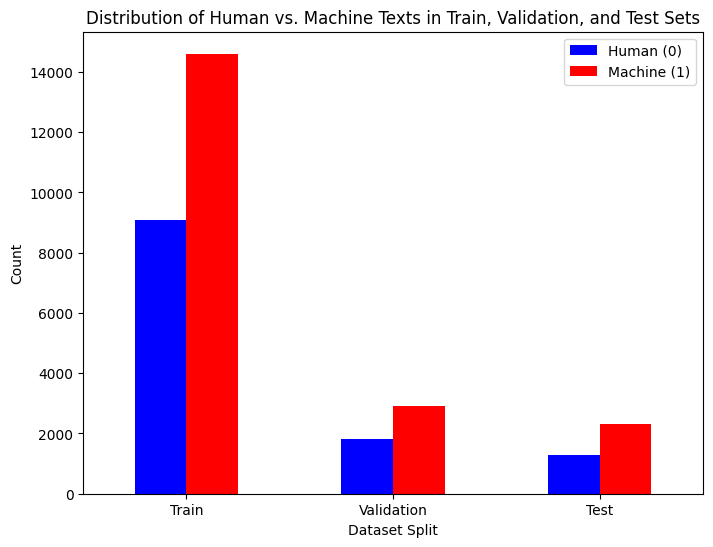

In [8]:
print("0 -> human | 1 -> machine")
print()


df_counts = pd.DataFrame({
    "Train": corpus_train_docs['label'].value_counts().sort_index(),
    "Validation": corpus_val_docs['label'].value_counts().sort_index(),
    "Test": corpus_test_docs['label'].value_counts().sort_index()
}).T 

# Plot the data
df_counts.plot(kind="bar", figsize=(8, 6), color=["blue", "red"])

# Formatting the plot
plt.xlabel("Dataset Split")
plt.ylabel("Count")
plt.title("Distribution of Human vs. Machine Texts in Train, Validation, and Test Sets")
plt.xticks(rotation=0)
plt.legend(["Human (0)", "Machine (1)"])

# Show the plot
plt.show()

TASK 1: Doc LEN Metrics

In [9]:
human_train_docs = corpus_train_docs[corpus_train_docs['label']==0].copy()
machine_train_docs = corpus_train_docs[corpus_train_docs['label']==1].copy()
human_val_docs = corpus_val_docs[corpus_val_docs['label']==0].copy()
machine_val_docs = corpus_val_docs[corpus_val_docs['label']==1].copy()
human_test_docs = corpus_test_docs[corpus_test_docs['label']==0].copy()
machine_test_docs = corpus_test_docs[corpus_test_docs['label']==1].copy()

print("***** Doc len metrics TRAIN (min, max, mean):")
print("train_set_distro:          ", dataset_doc_len(corpus_train_docs))
print("human_train_docs_distro:   ", dataset_doc_len(human_train_docs))
print("machine_train_docs_distro: ", dataset_doc_len(machine_train_docs))
print()
print("***** Doc len metrics VAL (min, max, mean):")
print("val_set_distro:          ", dataset_doc_len(corpus_val_docs))
print("human_val_docs_distro:   ", dataset_doc_len(human_val_docs))
print("machine_val_docs_distro: ", dataset_doc_len(machine_val_docs))
print()
print("***** Doc len metrics TEST (min, max, mean):")
print("test_set_distro:          ", dataset_doc_len(corpus_test_docs))
print("human_test_docs_distro:   ", dataset_doc_len(human_test_docs))
print("machine_test_docs_distro: ", dataset_doc_len(machine_test_docs))



***** Doc len metrics TRAIN (min, max, mean):
train_set_distro:           (33, 4892, 621)
human_train_docs_distro:    (150, 4892, 695)
machine_train_docs_distro:  (33, 2018, 574)

***** Doc len metrics VAL (min, max, mean):
val_set_distro:           (139, 4562, 616)
human_val_docs_distro:    (150, 4562, 690)
machine_val_docs_distro:  (139, 1987, 569)

***** Doc len metrics TEST (min, max, mean):
test_set_distro:           (114, 2892, 608)
human_test_docs_distro:    (155, 2892, 702)
machine_test_docs_distro:  (114, 2106, 556)


TASK 1: MODEL Distro

************************************ TRAIN SET: 
model
human                           9101
gpt-3.5-turbo                   1374
gpt-4o-mini                     1358
gpt-4o                          1336
ministral-8b-instruct-2410      1100
gemini-2.0-flash                1079
o3-mini                         1075
gemini-1.5-pro                  1072
llama-3.1-8b-instruct           1063
deepseek-r1-distill-qwen-32b     901
falcon3-10b-instruct             879
llama-3.3-70b-instruct           405
gpt-4.5-preview                  278
gemini-pro                       276
gpt-4-turbo-paraphrase           276
gpt-4-turbo                      272
qwen1.5-72b-chat-8bit            271
llama-2-70b-chat                 269
mistral-7b-instruct-v0.2         266
gemini-pro-paraphrase            265
text-bison-002                   265
mixtral-8x7b-instruct-v0.1       264
llama-2-7b-chat                  262
Name: count, dtype: int64

************************************ VAL SET: 
model
human         

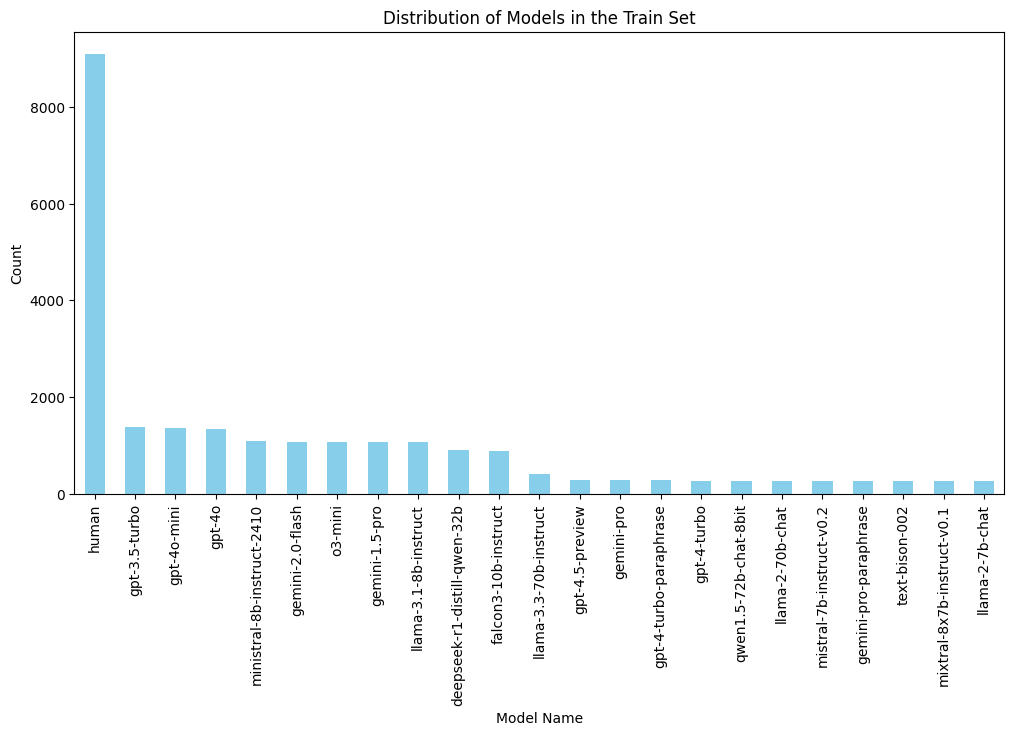

In [12]:
print("************************************ TRAIN SET: ")
print(corpus_train_docs['model'].value_counts(normalize=False))
print()
print("************************************ VAL SET: ")
print(corpus_val_docs['model'].value_counts(normalize=False))
print()
print("************************************ TEST TEST: ")
print(corpus_test_docs['model'].value_counts(normalize=False))

# Plot the data
plt.figure(figsize=(12, 6))
corpus_train_docs['model'].value_counts().plot(kind='bar', color="skyblue")

# Formatting the plot
plt.xlabel("Model Name")
plt.ylabel("Count")
plt.title("Distribution of Models in the Train Set")
plt.xticks(rotation=90)  # Rotate labels for readability

# Show the plot
plt.show()

TASK 1: GENRE Distro

************************************ TRAIN SET: 
genre
fiction    0.619943
essays     0.196609
news       0.183448
Name: proportion, dtype: float64

************************************ VAL SET: 
genre
fiction    0.609658
essays     0.205188
news       0.185154
Name: proportion, dtype: float64

************************************ TEST SET: 
genre
fiction    0.511842
news       0.302870
essays     0.185288
Name: proportion, dtype: float64


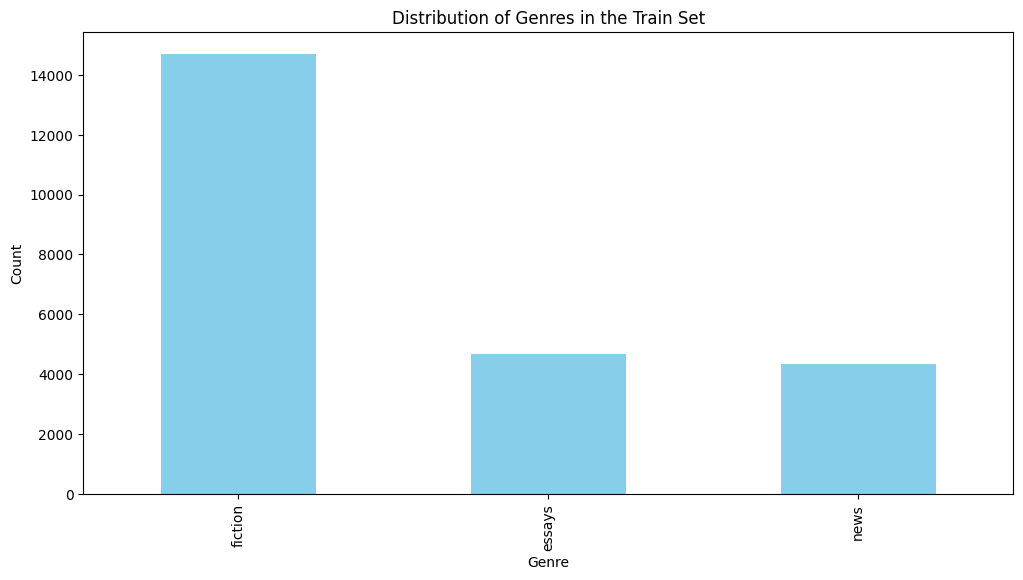

In [13]:
print("************************************ TRAIN SET: ")
print(corpus_train_docs['genre'].value_counts(normalize=True))
print()
print("************************************ VAL SET: ")
print(corpus_val_docs['genre'].value_counts(normalize=True))
print()
print("************************************ TEST SET: ")
print(corpus_test_docs['genre'].value_counts(normalize=True))

# Plot the data
plt.figure(figsize=(12, 6))
corpus_train_docs['genre'].value_counts().plot(kind='bar', color="skyblue")

# Formatting the plot
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Genres in the Train Set")
plt.xticks(rotation=90)  # Rotate labels for readability

# Show the plot
plt.show()

TASK 1: INSTANCE Example

In [11]:
print(human_train_docs.iloc[0], '\n', human_train_docs.iloc[0]['text'])
#print(human_train_docs.iloc[1], '\n', human_train_docs.iloc[1]['text'])
#print(human_train_docs.iloc[2], '\n', human_train_docs.iloc[2]['text'])

id                       d1c5aada-4927-53a5-baf6-2d39e36f5af5
text        "Journey! is she goin' off? 'taint on her wedd...
model                                                   human
label                                                       0
genre                                                 fiction
word_len                                                  671
Name: 13338, dtype: object 
 "Journey! is she goin' off? 'taint on her weddin' trip, is it? I heerd there was talk of her gettin' married, and I said then I was bound to have a finger in that pie--makin' the weddin' cake."

"Oh, no, she's quite too young for that yet," Mrs. Keith said, with a slight smile, "she's only going South on a visit to some relations."

"And I want you to promise to stay and take care of mother till I come back, Celestia Ann," added Mildred.

"Well, you've got to promise first that you'll not stay forever," prudently stipulated Miss Hunsinger. "When do you 'low to come back?"

"Next spring."

"H'

In [13]:
print(machine_train_docs.iloc[0], '\n', machine_train_docs.iloc[0]['text'])
#print(machine_train_docs.iloc[1], '\n', machine_train_docs.iloc[1]['text'])
#print(machine_train_docs.iloc[2], '\n', machine_train_docs.iloc[2]['text'])

id                       a9fcc655-2beb-5e9e-b1b9-687f9dd9b733
text        The American education system has increasingly...
model                            deepseek-r1-distill-qwen-32b
label                                                       1
genre                                                  essays
word_len                                                  458
Name: 2177, dtype: object 
 The American education system has increasingly prioritized standardized testing over critical thinking, creating a "banking model" where students are seen as empty accounts to be filled with information rather than active participants in their own learning. This shift has stifened creativity and independent thought, fostering a generation that feels disempowered and disconnected from systemic issues. Yet, despite this, young activists are challenging the status quo, advocating for policies that address corporate greed, corruption, and the rigged job market. Their protests, often met with polic

ML - BASELINE

In [14]:
def get_metrics(predicted, labels, target_names, subset='val'):
    print(f'Accuracy {subset}:', np.mean(predicted == labels))  
    print(f'F1Score {subset}:', f1_score(labels, predicted , average='macro'))
    #print(metrics.classification_report(labels, predicted, target_names=target_names))
    #print(f"Matriz Confusion {subset}: ")
    #print(metrics.confusion_matrix(labels, predicted))

def build_pipeline(model_algo, model_args):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(lowercase=True, analyzer='word', stop_words='english', ngram_range=(1,1))),
        ('clf', CalibratedClassifierCV(model_algo(**model_args))),
    ])
    return pipeline

def train(train_set, model_algo, model_args):
    pipeline = build_pipeline(model_algo, model_args)
    pipeline.fit(train_set['text'], train_set['label'])
    return pipeline

def test(texts, labels, model, target_names, subset='val'):
    predicted = model.predict(texts)
    get_metrics(predicted, labels, target_names, subset=subset)

def baselines(train_set, val_set, test_set, target_names=['human', 'generated'], model='SGDClassifier'):
    print('training model...')
    print("train_set: ", len(train_set))
    print("val_set: ", len(val_set))
    print("test_set: ", len(test_set))
    print('\n')
    model_train = train(train_set, model['algo'], model['args'])   
    test(texts=val_set['text'], labels=val_set['label'], model=model_train, target_names=target_names, subset='val')
    test(texts=test_set['text'], labels=test_set['label'], model=model_train, target_names=target_names, subset='test')
    

In [15]:
#'LinearSVC', 'MultinomialNB', 'LogisticRegression', 'xgb.XGBClassifier', 'SGDClassifier'

models = [
    {"algo": LinearSVC, "args": {"dual": "auto","random_state": 42}},
    {"algo": LogisticRegression, "args": {}},
    {"algo": SGDClassifier, "args": {}},
]


for model in models:
    print(40*'*', 'model: ', model)
    baselines(
        train_set=corpus_train_docs[ : ], 
        val_set=corpus_val_docs[ : ], 
        test_set=corpus_test_docs[ : ],  
        target_names=['human', 'generated'], # human -> 0 | machine -> 1
        model=model,
    )
    print('\n')

**************************************** model:  {'algo': <class 'sklearn.svm._classes.LinearSVC'>, 'args': {'dual': 'auto', 'random_state': 42}}
training model...
train_set:  23707
val_set:  2512
test_set:  1077




Accuracy val: 0.9828821656050956
F1Score val: 0.9813079163265529
Accuracy test: 0.9758588672237697
F1Score test: 0.9736005520861617


**************************************** model:  {'algo': <class 'sklearn.linear_model._logistic.LogisticRegression'>, 'args': {}}
training model...
train_set:  23707
val_set:  2512
test_set:  1077


Accuracy val: 0.9665605095541401
F1Score val: 0.9634203168685928
Accuracy test: 0.9656453110492108
F1Score test: 0.9623641747063907


**************************************** model:  {'algo': <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>, 'args': {}}
training model...
train_set:  23707
val_set:  2512
test_set:  1077


Accuracy val: 0.9745222929936306
F1Score val: 0.9721439625961728
Accuracy test: 0.9730733519034355
F1Score test: 0.970571912868063




READ AND EXPLORE TASK 2

In [13]:
corpus_train_docs_t2, corpus_val_docs_t2 = read_pan25_dataset(dataset_dir=TASK_2_DIR)
corpus_train_docs_t2

,text,language,label,source_dataset,model,label_text
98368,I'm going to answer about wine because I don't...,English,0,LLM-DetectAIve,human,fully human-written
127338,"Law enforcement officer here, and the answer v...",English,1,LLM-DetectAIve,gpt-4o,"human-written, then machine-polished"
213787,Fire isn't considered a separate state of matt...,English,2,LLM-DetectAIve,mixtral-8x7b,"machine-written, then machine-humanized"
186304,"Let's take a closer look at the famed ""face on...",English,2,LLM-DetectAIve,llama3-8b,"machine-written, then machine-humanized"
163648,We explore how the arrangement of layers in di...,English,2,LLM-DetectAIve,llama3-70b,"machine-written, then machine-humanized"
...,...,...,...,...,...,...
3310,I THINK THE AUTHOR ENDS THE STORY WITH THAT PA...,English,3,TriBERT,chatgpt,"human-initiated, then machine-continued"
263270,"Abraham Harawitz, born on May 8, 1879 in Minsk...",English,1,LLM-DetectAIve,mistral-7b,"human-written, then machine-polished"
88315,Pocket Trains is a mobile simulation game deve...,English,2,LLM-DetectAIve,gpt-4o,"machine-written, then machine-humanized"
41429,Luke Boberger's decision to join the program w...,English,1,LLM-DetectAIve,llama3-70b,"human-written, then machine-polished"


In [14]:
print("************************************ TRAIN SET: ")
print(corpus_train_docs_t2.info())
print()
print("************************************ VAL SET: ")
print(corpus_val_docs_t2.info())

************************************ TRAIN SET: 
<class 'pandas.core.frame.DataFrame'>
Index: 288918 entries, 98368 to 232335
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            288918 non-null  object
 1   language        288918 non-null  object
 2   label           288918 non-null  int64 
 3   source_dataset  288918 non-null  object
 4   model           288918 non-null  object
 5   label_text      288918 non-null  object
dtypes: int64(1), object(5)
memory usage: 15.4+ MB
None

************************************ VAL SET: 
<class 'pandas.core.frame.DataFrame'>
Index: 72661 entries, 37728 to 30414
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            72661 non-null  object
 1   language        72661 non-null  object
 2   label           72661 non-null  int64 
 3   source_dataset  72661 non-null  object
 4   mo

['fully human-written' 'human-written, then machine-polished'
 'machine-written, then machine-humanized'
 'deeply-mixed text; where some parts are written by a human and some are generated by a machine'
 'human-initiated, then machine-continued'
 'machine-written, then human-edited']
                                               label_text  label
98368                                 fully human-written      0
127338               human-written, then machine-polished      1
213787            machine-written, then machine-humanized      2
23873             human-initiated, then machine-continued      3
5783    deeply-mixed text; where some parts are writte...      4
672                    machine-written, then human-edited      5

************************************ TRAIN SET (288918): 
label
1    0.330191
2    0.315771
0    0.260524
4    0.051606
3    0.037173
5    0.004735
Name: proportion, dtype: float64

************************************ VAL SET (35603): 
label
3    0.511558
0 

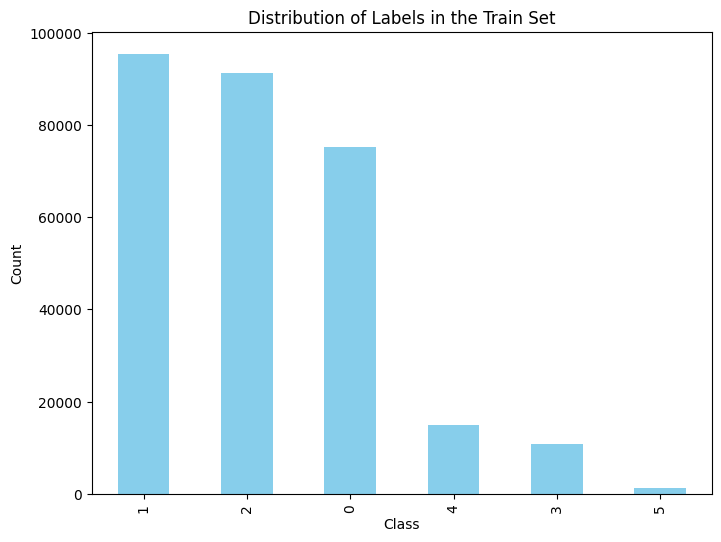

In [40]:
print(corpus_train_docs_t2['label_text'].unique())
print(corpus_train_docs_t2[['label_text', 'label']].drop_duplicates().sort_values(by='label'))
print()
print(f"************************************ TRAIN SET ({corpus_train_docs_t2.shape[0]}): ")
print(corpus_train_docs_t2['label'].value_counts(normalize=True))

# Split data into 80% train and 20% test, stratifying by the 'label' column
corpus_val_docs_t2, corpus_test_docs_t2 = train_test_split(corpus_val_docs_t2, test_size=0.3, random_state=42, stratify=corpus_val_docs_t2['label'])
print()
print(f"************************************ VAL SET ({corpus_val_docs_t2.shape[0]}): ")
print(corpus_val_docs_t2['label'].value_counts(normalize=True))
print()
print(f"************************************ TEST SET ({corpus_test_docs_t2.shape[0]}): ")
print(corpus_test_docs_t2['label'].value_counts(normalize=True))


# Plot the data
plt.figure(figsize=(8, 6))
corpus_train_docs_t2['label'].value_counts().plot(kind='bar', color="skyblue")

# Formatting the plot
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Labels in the Train Set")
plt.xticks(rotation=90)  # Rotate labels for readability

# Show the plot
plt.show()

In [25]:
print(f"************************************ TRAIN SET: ")
print(corpus_train_docs_t2['language'].value_counts(normalize=True))
print(f"************************************ TRAIN SET: ")
print(corpus_val_docs_t2['language'].value_counts(normalize=True))
print(f"************************************ TRAIN SET: ")
print(corpus_test_docs_t2['language'].value_counts(normalize=True))

************************************ TRAIN SET: 
language
English    1.0
Name: proportion, dtype: float64
************************************ TRAIN SET: 
language
English    1.0
Name: proportion, dtype: float64
************************************ TRAIN SET: 
language
English    1.0
Name: proportion, dtype: float64


In [27]:
print(f"************************************ TRAIN SET: ")
print(corpus_train_docs_t2['source_dataset'].value_counts(normalize=True))
print(f"************************************ TRAIN SET: ")
print(corpus_val_docs_t2['source_dataset'].value_counts(normalize=True))
print(f"************************************ TRAIN SET: ")
print(corpus_test_docs_t2['source_dataset'].value_counts(normalize=True))

************************************ TRAIN SET: 
source_dataset
LLM-DetectAIve    0.891436
TriBERT           0.073301
RoFT_chatgpt      0.024021
Coauthor          0.005008
LAMP              0.004423
MixSet            0.001810
Name: proportion, dtype: float64
************************************ TRAIN SET: 
source_dataset
m4gt-bench        0.440879
LLM-DetectAIve    0.393693
RoFT              0.124789
MixSet            0.040639
Name: proportion, dtype: float64
************************************ TRAIN SET: 
source_dataset
m4gt-bench        0.435983
LLM-DetectAIve    0.394192
RoFT              0.128492
MixSet            0.041332
Name: proportion, dtype: float64


In [ ]:
'''
0 -> 'fully human-written'
1 -> 'human-written, then machine-polished', 
2 -> 'machine-written, then machine-humanized',
3 -> 'human-initiated, then machine-continued', 
4 -> 'deeply-mixed text; where some parts are written by a human and some are generated by a machine',
5 -> 'machine-written, then human-edited'
'''

train_docs_class0 = corpus_train_docs_t2[corpus_train_docs_t2['label']==0].copy()
train_docs_class1 = corpus_train_docs_t2[corpus_train_docs_t2['label']==1].copy()
train_docs_class2 = corpus_train_docs_t2[corpus_train_docs_t2['label']==2].copy()
train_docs_class3 = corpus_train_docs_t2[corpus_train_docs_t2['label']==3].copy()
train_docs_class4 = corpus_train_docs_t2[corpus_train_docs_t2['label']==4].copy()
train_docs_class5 = corpus_train_docs_t2[corpus_train_docs_t2['label']==5].copy()

print("* Doc len metrics TRAIN (min, max, mean):")
print("train_set_distro:    ", dataset_doc_len(corpus_train_docs_t2))
print("train_docs_class_0:  ", dataset_doc_len(train_docs_class0))
print("train_docs_class_1:  ", dataset_doc_len(train_docs_class1))
print("train_docs_class_2:  ", dataset_doc_len(train_docs_class2))
print("train_docs_class_3:  ", dataset_doc_len(train_docs_class3))
print("train_docs_class_4:  ", dataset_doc_len(train_docs_class4))
print("train_docs_class_5:  ", dataset_doc_len(train_docs_class5))
print()


***** Doc len metrics TRAIN (min, max, mean):
train_set_distro:    (0, 33222, 343)
train_docs_class_0:  (0, 33222, 533)
train_docs_class_1:  (1, 5653, 287)
train_docs_class_2:  (1, 2279, 272)
train_docs_class_3:  (32, 3139, 219)
train_docs_class_4:  (60, 1358, 277)
train_docs_class_5:  (59, 409, 194)



In [ ]:
#'LinearSVC', 'MultinomialNB', 'LogisticRegression', 'xgb.XGBClassifier', 'SGDClassifier'

models = [
    {"algo": LinearSVC, "args": {"dual": "auto","random_state": 42}},
    {"algo": LogisticRegression, "args": {"solver": "lbfgs", "max_iter": 500, "random_state": 42}},
    {"algo": SGDClassifier, "args": {}},
    {"algo": xgb.XGBClassifier, "args": {"n_jobs": -1}},
]


for model in models:
    print(40*'*', 'model: ', model)
    baselines(
        train_set=corpus_train_docs_t2[ : ], 
        val_set=corpus_val_docs_t2[ : ], 
        test_set=corpus_test_docs_t2[ : ],  
        target_names=['fully human-written', 'human-written, then machine-polished', 'machine-written, then machine-humanized',
                      'human-initiated, then machine-continued', 'deeply-mixed text; where some parts are written by a human and some are generated by a machine',
                      'machine-written, then human-edited'],
        model=model,
    )
    print('\n')



'''
0 -> 'fully human-written'
1 -> 'human-written, then machine-polished', 
2 -> 'machine-written, then machine-humanized',
3 -> 'human-initiated, then machine-continued', 
4 -> 'deeply-mixed text; where some parts are written by a human and some are generated by a machine',
5 -> 'machine-written, then human-edited'
'''

**************************************** model:  {'algo': <class 'sklearn.svm._classes.LinearSVC'>, 'args': {'dual': 'auto', 'random_state': 42}}
training model...
train_set:  288918
val_set:  50862
test_set:  21799


Accuracy val: 0.5050922102945224
F1Score val: 0.4244043642406424
Accuracy test: 0.5067663654296068
F1Score test: 0.43045373574428897


**************************************** model:  {'algo': <class 'sklearn.linear_model._logistic.LogisticRegression'>, 'args': {'solver': 'lbfgs', 'max_iter': 500, 'random_state': 42}}
training model...
train_set:  288918
val_set:  50862
test_set:  21799


Accuracy val: 0.48346506232550823
F1Score val: 0.35505941390777657
Accuracy test: 0.48226982889123354
F1Score test: 0.3515676385612967


**************************************** model:  {'algo': <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>, 'args': {}}
training model...
train_set:  288918
val_set:  50862
test_set:  21799


Accuracy val: 0.48161692422633795
F1Score va